In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tensorboard
from torch.utils.tensorboard import SummaryWriter

/home/shah/miniconda3/envs/rtx_3060/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

True

In [3]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [4]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 7730), started 12:59:53 ago. (Use '!kill 7730' to kill it.)

In [5]:
cudnn.benchmark = True
plt.ion()   # interactive mode
writer = SummaryWriter()

# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ])
}

path_dir = '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/data_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(path_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
                  
train_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
test_dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=0)
              for x in ['test']}


dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes
#class_names = {k: v for v, k in enumerate(class_names)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
len(image_datasets)

In [ ]:
image_datasets['train']

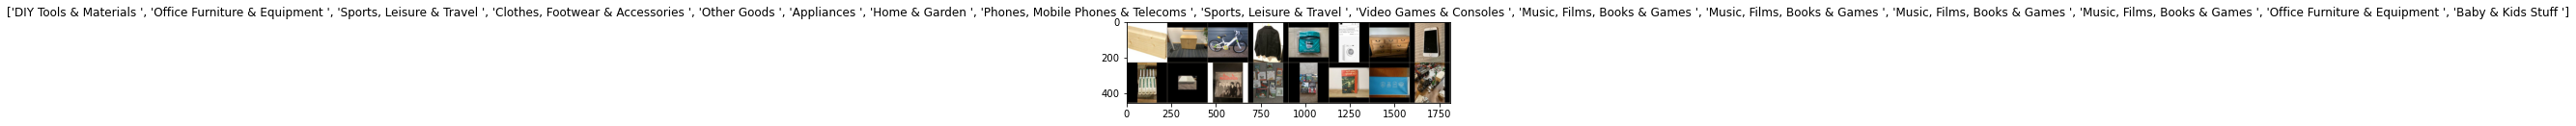

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs, batch_size):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                print("Training in progress")
                model.train()  
            elif phase == 'val':
                print("Validating in progress")
                model.eval()   
            
            num_corrects = 0
            num_samples = 0
            counter = 0

            # Iterate over data.
            for inputs, labels in train_dataloaders[phase]:

                inputs = inputs.to(device)
                labels = labels.to(device)

                #with torch.set_grad_enabled(phase == 'train'):
                counter += 1
                predict = model(inputs)
                labels = labels
                _, preds = torch.max(predict, 1)
                loss = criterion(predict, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if counter % 10 == 9:
                    print(f'[{epoch + 1}, {counter + 1:5d}] loss: {loss}')
                    if phase == 'train':
                        writer.add_scalar('Training Loss', loss, epoch)
                    else:
                        writer.add_scalar('Validation Loss', loss, epoch)

                  
                num_corrects += torch.sum(preds == labels).sum()
                num_samples += preds.size(0)

            if phase == 'train':
                scheduler.step()
            
            acc = float(num_corrects) / num_samples

            print(f'Got {num_corrects} / {num_samples} with accuracy: {acc * 100}%')
            writer.add_scalar('Training Accuracy', acc, epoch)
            writer.add_scalar('Validation Accuracy', acc, epoch)
            # input("EPOCH COMPLETE: Press Enter to continue...")

            # deep copy the model
            if phase == 'val' and acc > best_acc:
                best_acc = acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/home/shah/Desktop/FB-Marketplace-Recommendation-Ranking-System/data/model_state_dict.pt')
    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [21]:
def test_model(model, len_labels):

    # Load the model that we saved at the end of the training loop   
    label_correct = 0
    num_samples = 0
  
    with torch.no_grad(): 
        for inputs, labels in test_dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1) 

            num_samples += preds.size(0)
            label_correct += (preds == labels).sum()
        acc = float(label_correct) / num_samples

        print(f'Test Accuracy of the model: {label_correct}/ {num_samples} with accuracy of: {acc * 100}%')

In [22]:
test_model(model_ft, len_labels=13)

Test Accuracy of the model: 623/ 1167 with accuracy of: 53.384747215081404%


In [10]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.features = models.resnet50(pretrained=True)
        for i, param in enumerate(self.features.parameters()):
            if i  < 47: #freeze 47 layers
                param.requires_grad = False
            else:
                param.requires_grad = True
        self.features.fc = nn.Sequential(
                nn.Linear(2048, 1024),    
                nn.ReLU(),
                nn.Dropout(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                #nn.Dropout(),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Linear(128, 13))
    
    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.reshape[0], -1)
        return x

In [ ]:
#from torchsummary import summary
#writer = SummaryWriter()
#model = models.resnet50(pretrained=True)
#summary(model, (3, 224, 224), device = 'cpu')

Epoch 1/30
----------
Training in progress
[1,    10] loss: 2.5705647468566895
[1,    20] loss: 2.555879592895508
[1,    30] loss: 2.5365474224090576
[1,    40] loss: 2.4920454025268555
[1,    50] loss: 2.504490613937378
[1,    60] loss: 2.546205759048462
[1,    70] loss: 2.4555139541625977
[1,    80] loss: 2.529792308807373
[1,    90] loss: 2.3421671390533447
[1,   100] loss: 2.4661455154418945
[1,   110] loss: 2.1940197944641113
[1,   120] loss: 2.3233702182769775
[1,   130] loss: 2.675575017929077
[1,   140] loss: 2.2140402793884277
[1,   150] loss: 2.127840518951416
[1,   160] loss: 2.589200019836426
[1,   170] loss: 2.5729289054870605
[1,   180] loss: 2.3662426471710205
[1,   190] loss: 2.565232753753662
[1,   200] loss: 1.7934696674346924
[1,   210] loss: 2.127129554748535
[1,   220] loss: 2.2270686626434326
[1,   230] loss: 2.24212384223938
[1,   240] loss: 2.1433539390563965
[1,   250] loss: 2.191506862640381
[1,   260] loss: 2.115468978881836
[1,   270] loss: 2.221075534820556

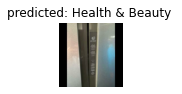

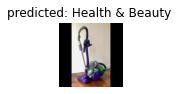

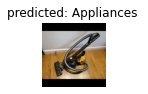

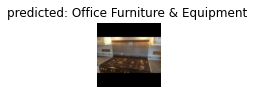

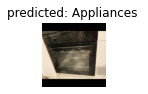

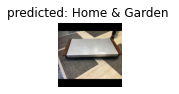

Test Accuracy of the model: 623/ 1167 with accuracy of: 53.384747215081404%


In [11]:
model = CNN().to(device) #Fine tune model
model_ft = model.features

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30, batch_size=16)

visualize_model(model_ft)
input("visualizing model")
#test_model(model_ft, 13)
writer.flush()
plt.ioff()
plt.show()

In [ ]:
#To save the model
#torch.save(model_ft, "data/image_model.pt")

#To load the model
#torch.load("data/image_model.pt")
#model.eval()

